# Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения

In [12]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [13]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
scipy 1.2.1
pandas 0.24.2
matplotlib 3.1.0
statsmodels 0.10.0
sklearn 0.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   : a0fa91f2268c4738f3a79e068ca43360b31d66f7


In [14]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [15]:
PATH_TO_DATA = r'C:\Users\Диас\Desktop\DiaStudy\internet user identification\1 data preparation'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [16]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [17]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [19]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [20]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [22]:
knn_pred_split = knn_model.fit(X_train, y_train).predict(X_valid)
knn_score_split = accuracy_score(y_valid, knn_pred_split)

In [23]:
knn_score_cv = cross_val_score(knn_model, X_train, y_train, cv=skf).mean()

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [24]:
with open("answer4_1.txt", 'w') as fout:
    fout.write(f'{knn_score_cv:.3f} {knn_score_split:.3f}')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17, n_jobs=-1)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [26]:
rf_predict_split = rf_model.fit(X_train, y_train).predict(X_valid)
rf_score_split = accuracy_score(y_valid, rf_predict_split)

In [27]:
rf_score_cv = np.mean(cross_val_score(rf_model, X_train, y_train, cv=skf))

In [28]:
with open("answer4_2.txt", 'w') as fout:
    fout.write(f'{rf_score_cv:.3f} {rf_score_split:.3f}')

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [29]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logit = LogisticRegression(random_state=17)

In [30]:
logit_score_cv = np.mean(cross_val_score(logit, X_train, y_train, cv=skf))

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [89]:
%%time

logit_c_values1 = np.logspace(1e-4, 1e2, 10)

logit_grid_searcher1 = GridSearchCV(logit, param_grid = {"C": logit_c_values1}, cv=skf, return_train_score=True)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 52 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(random_state=17),
             param_grid={'C': array([1.00023029e+000, 1.29181404e+011, 1.66839930e+022, 2.15476543e+033,
       2.78291537e+044, 3.59418146e+055, 4.64194510e+066, 5.99514926e+077,
       7.74283492e+088, 1.00000000e+100])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [90]:
logit_grid_searcher1.best_score_, logit_grid_searcher1.best_params_ 

(0.7607204451349604, {'C': 1.0002302850208247})

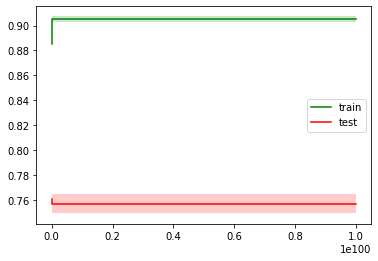

In [92]:
plot_validation_curves(logit_c_values1, logit_grid_searcher1.cv_results_)

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [93]:
%%time

logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = GridSearchCV(logit, param_grid = {"C": logit_c_values2}, cv=skf, return_train_score=True)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LogisticRegression(random_state=17),
             param_grid={'C': array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [94]:
logit_grid_searcher2.best_score_, logit_grid_searcher2.best_params_

(0.7626511226252158, {'C': 1.9157894736842107})

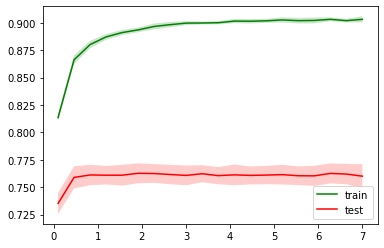

In [95]:
plot_validation_curves(logit_c_values2, logit_grid_searcher2.cv_results_)

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [35]:
logit_score_cv = np.mean(cross_val_score(logit_grid_searcher2.best_estimator_, X_train, y_train, cv=skf))
logit_score_split = accuracy_score(y_valid, logit_grid_searcher2.best_estimator_.fit(X_train, y_train).predict(X_valid))

In [36]:
with open("answer4_3.txt", 'w') as fout:
    fout.write(f'{logit_score_cv:.3f} {logit_score_split:.3f}')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [37]:
from sklearn.svm import LinearSVC

In [38]:
svm = LinearSVC(C=1, random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [96]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, cv=skf, return_train_score=True)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 1min 35s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17),
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [97]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.694880724942574, {'C': 8888.8889})

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [ ]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, cv=skf, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [43]:
svm_score_cv = np.mean(cross_val_score(svm_grid_searcher2.best_estimator_, X_train, y_train, cv=skf))
svm_score_split = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.fit(X_train, y_train).predict(X_valid))

In [44]:
with open("answer4_4.txt", 'w') as fout:
    fout.write(f'{svm_score_cv:.3f} {svm_score_split:.3f}')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [45]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):

    with open(path_to_X_pickle, 'rb') as fx: X = pickle.load(fx)
    with open(path_to_y_pickle, 'rb') as fy: y = pickle.load(fy)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state,
                                                        stratify=y)
    
    estimator_score_cv = np.mean(cross_val_score(estimator, X_train, y_train, cv=cv))
    estimator_score_split = accuracy_score(y_test, estimator.fit(X_train, y_train).predict(X_test))
    
    return estimator_score_cv, estimator_score_split

**Убедитесь, что функция работает.**

In [46]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7674269259074791, 0.7819388480682626)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [47]:
PATH_TO_DATA2 = r'C:\Users\Диас\Desktop\DiaStudy\internet user identification\2 hypotheses analysis'

In [48]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA2, f'X_sparse_10users_s{session_length}_w{window_size}.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA2, f'y_10users_s{session_length}_w{window_size}.pkl')
        
        score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_,
                                                 path_to_X_pickle=path_to_X_pkl, 
                                                 path_to_y_pickle=path_to_y_pkl, 
                                                 cv=skf)
        
        print(f"Parameters: window_size: {window_size}, session_length: {session_length}")
        print(f"Scores: cv: {score_cv}, split: {score_split}")
        print()

Parameters: window_size: 10, session_length: 15
Scores: cv: 0.8146726161714527, split: 0.8328987911827447

Parameters: window_size: 10, session_length: 10
Scores: cv: 0.7674269259074791, split: 0.7819388480682626

Parameters: window_size: 7, session_length: 15
Scores: cv: 0.8416788984451413, split: 0.8450306952049113

Parameters: window_size: 7, session_length: 10
Scores: cv: 0.7865580836233855, split: 0.7904430064708811

Parameters: window_size: 7, session_length: 7
Scores: cv: 0.7347796199129073, split: 0.7449809191969471

Parameters: window_size: 5, session_length: 15
Scores: cv: 0.8591602044849895, split: 0.8694879089615932

Parameters: window_size: 5, session_length: 10
Scores: cv: 0.807285614179873, split: 0.8160265528686581

Parameters: window_size: 5, session_length: 7
Scores: cv: 0.7535308264033714, split: 0.7625651967757231

Parameters: window_size: 5, session_length: 5
Scores: cv: 0.7002335493176605, split: 0.7095779990516833

Wall time: 53.5 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [49]:
%%time

score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_, 
                                         path_to_X_pickle=os.path.join(PATH_TO_DATA2, 'X_sparse_10users_s15_w5.pkl'),
                                         path_to_y_pickle=os.path.join(PATH_TO_DATA2, 'y_10users_s15_w5.pkl'), 
                                         cv=skf, random_state=17, test_size=0.3)

Wall time: 13.1 s


In [50]:
with open("answer4_5.txt", 'w') as fout:
    fout.write(f'{score_cv:.3f} {score_split:.3f}')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [51]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA2, f'X_sparse_150users_s{session_length}_w{window_size}.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA2, f'y_150users_s{session_length}_w{window_size}.pkl')
        
    score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_,
                                            path_to_X_pickle=path_to_X_pkl, 
                                            path_to_y_pickle=path_to_y_pkl, 
                                            cv=skf)
        
    print(f"Parameters: window_size: {window_size}, session_length: {session_length}")
    print(f"Scores: cv: {score_cv}, split: {score_split}")
    print()

Parameters: window_size: 5, session_length: 5
Scores: cv: 0.38194390125619887, split: 0.394437144108629

Parameters: window_size: 7, session_length: 7
Scores: cv: 0.4186849443057563, split: 0.43274176516674046

Parameters: window_size: 10, session_length: 10
Scores: cv: 0.4629403730464066, split: 0.48340874811463047

Wall time: 26min 23s


**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [52]:
%%time

score_cv, score_split = model_assessment(estimator=svm_grid_searcher2.best_estimator_, 
                                         path_to_X_pickle=os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
                                         path_to_y_pickle=os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 
                                         cv=skf, random_state=17, test_size=0.3)

Wall time: 10min 19s


In [53]:
with open("answer4_6.txt", 'w') as fout:
    fout.write(f'{score_cv:.3f} {score_split:.3f}')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [54]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [55]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [56]:
best_param = [logit_grid_searcher2.best_params_['C']]

In [102]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=best_param, multi_class='ovr', 
                                         n_jobs=-1, random_state=17)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 16min 35s


LogisticRegressionCV(Cs=[1.9157894736842107], multi_class='ovr', n_jobs=-1,
                     random_state=17)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [103]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id, logit_cv_150users.scores_[user_id].mean()))

User 1, CV score: 0.9961006282970469
User 2, CV score: 0.9964134150184119
User 3, CV score: 0.9953395312258225
User 4, CV score: 0.992076167016406
User 5, CV score: 0.9903558400488981
User 6, CV score: 0.9943177687700093
User 7, CV score: 0.993848591949112
User 8, CV score: 0.986081132215773
User 9, CV score: 0.9980190364547321
User 10, CV score: 0.9952665515708844
User 11, CV score: 0.9946097020649383
User 12, CV score: 0.9937756144682744
User 13, CV score: 0.9968930193678147
User 14, CV score: 0.994745236563934
User 15, CV score: 0.9963300034867677
User 16, CV score: 0.9963612877028598
User 17, CV score: 0.9907207589775409
User 18, CV score: 0.9944324569083948
User 19, CV score: 0.9946096993473128
User 20, CV score: 0.9914401660451702
User 21, CV score: 0.9807742365724291
User 22, CV score: 0.9968825940134094
User 23, CV score: 0.9948390669276825
User 24, CV score: 0.9910752427683269
User 25, CV score: 0.9966323670278276
User 26, CV score: 0.9942760640912371
User 27, CV score: 0.9951

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [104]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - (1 - class_distr[user_id]/sum(class_distr))

In [105]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [106]:
with open('answer4_7.txt', 'w') as fout:
    fout.write(f'{num_better_than_default/len(list(acc_diff_vs_constant)):.3f}')